# DATASET LOADING
Using a jupyter notebook as loading all images takes a long time and jupyter notebooks allows us to keep it loaded into memory

In [ ]:
#dependencies
%pip install scikit-learn
%pip install tensorflow
%pip install numpy
%pip install opencv-python
%pip install matplotlib
%pip install pickle-mixin
#%pip install tensorflow-gpu #if NVidia GPU with CUDA setup and SDK cuDNN

In [2]:
import numpy as np
import os
import cv2

#loading training set
images = []
labels = []

path = 'OCRDataset/training_data'
dir_list = os.listdir(path)
for i in dir_list:
    dir = os.path.join(path, i)
    file_list = os.listdir(dir)
    for j in file_list:
        files = os.path.join(dir, j)
        img = cv2.imread(files, 0) #grayscale
        img = cv2.resize(img, (64,64))
        img = np.array(img, dtype=np.float32)
        img = img/255
        images.append(img)
        labels.append(i)

#loading validation images
test_images = []
test_labels = []

path = 'OCRDataset/testing_data'

dir_list = os.listdir(path)
for i in dir_list:
  dir = os.path.join(path, i)
  file_list = os.listdir(dir)
  for j in file_list:
    files = os.path.join(dir, j)
    img = cv2.imread(files, 0) #grayscale
    img = cv2.resize(img, (64,64))
    img = np.array(img, dtype=np.float32)
    img = img/255
    test_images.append(img)
    test_labels.append(i)

Displaying first image

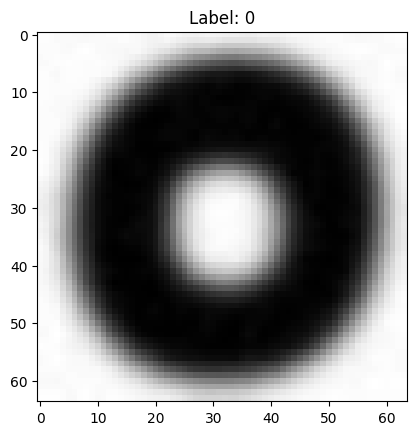

In [70]:
import matplotlib.pyplot as plt
from random import randint
# Display the image
idx = randint(0, 1007)
plt.imshow(images[idx], cmap="gray")
plt.title(f"Label: {labels[idx]}")
plt.show()

# Preparing the data
During this step we have to preprare the labels, shuffle and normalize the data for a better training

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import tensorflow.keras as keras

x_train = np.array(images)
y_train = np.array(labels)

x_valid = np.array(test_images)
y_valid = np.array(test_labels)


# convert to binary categories
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_valid = label_encoder.fit_transform(y_valid)

num_classes = len(set(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

#shuffle for better training
x_train, y_train = shuffle(x_train, y_train)
x_valid, y_valid = shuffle(x_valid, y_valid)

# Normalize our image data
x_train = x_train / 255
x_valid = x_valid / 255



#reshaping for CNN
x_train = x_train.reshape(-1,64,64,1)
x_valid = x_valid.reshape(-1,64,64,1)

x_train.shape, x_valid.shape, num_classes


((20628, 64, 64, 1), (1008, 64, 64, 1), 36)

# Model Creation

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(64, 64, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=(num_classes), activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 75)        750       
                                                                 
 batch_normalization_3 (Bat  (None, 64, 64, 75)        300       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 75)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 50)        33800     
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 50)        0         
                                                                 
 batch_normalization_4 (Bat  (None, 32, 32, 50)       

# Data Augmentation

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # Don't randomly flip images horizontally
    vertical_flip=False # Don't randomly flip images vertically
)  

Note that we disabled vertical and horizontal flip as the perspective transformation should put it in the right way

# Batch Size


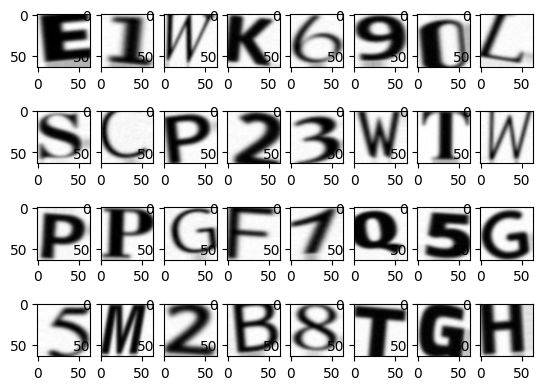

In [24]:
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image), cmap='gray')
plt.show()

# Fitting the Data to the Generator

In [25]:
datagen.fit(x_train)

# Compiling the Model

In [26]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

# Training with Augmentation

In [67]:
model.fit(img_iter,
          epochs=1,
          steps_per_epoch=len(x_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(x_valid, y_valid))

644/644 [==============================] - 78s 122ms/step - loss: 0.1120 - accuracy: 0.9594 - val_loss: 0.1076 - val_accuracy: 0.9573


# Saving the Model

Don't forget to save the LabelEncoder parameter as it will be required to decode the output during predictions

In [68]:
import pickle

model.save('Tensorflow\OCR_model_V2')
np.save('Tensorflow\OCR_model_V2\label_encoder.npy', label_encoder.classes_)

filehandler = open("Tensorflow\OCR_model_V2\le.obj","wb")
pickle.dump(label_encoder,filehandler)
filehandler.close()

INFO:tensorflow:Assets written to: Tensorflow\OCR_model_V2\assets


INFO:tensorflow:Assets written to: Tensorflow\OCR_model_V2\assets


# RELOAD MODEL

In [13]:
model = keras.models.load_model('Tensorflow\OCR_model_V2')

# Testing decode

32/32 [==============================] - 1s 27ms/step
(1008, 36)
[30 17  9 ... 17 15 16]
['U' 'H' '9' ... 'H' 'F' 'G']


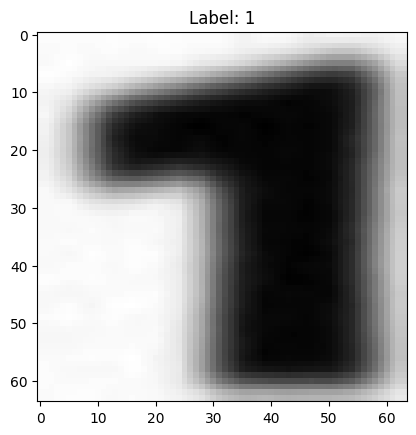

In [69]:
import matplotlib.pyplot as plt

preds = model.predict(x_valid)

print(preds.shape)
# Inverse transform the predicted probabilities to get the original class labels
#label_decoder = LabelEncoder()
#label_decoder.classes_ = np.load('Tensorflow\OCR_model_V2\label_encoder.npy')

file = open("Tensorflow\OCR_model_V2\le.obj",'rb')
label_decoder = pickle.load(file)
file.close()

predicted_labels = label_decoder.inverse_transform(np.argmax(preds, axis=1))

from random import randint

idx = randint(0, 1007)

out = np.argmax(preds, axis=1)
print(str(out))
print(str(predicted_labels))
#print(label_decoder.inverse_transform(out))

plt.imshow(x_valid[idx], cmap='gray')
plt.title(f"Label: {predicted_labels[idx]}")
plt.show()